In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import rasterio
import joblib

from tqdm import tqdm
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import confusion_matrix




In [2]:
def image_to_df(snow_path, mask_path, print_gabor=False, labeled=True):
    #load in images
    img = cv2.imread(snow_path)
    if labeled:
        mask = rasterio.open(mask_path)
    
    #generate grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #flatten image
    img2 = img.reshape((-1,3))

    #create dataframe
    df = pd.DataFrame(img2, columns=['B', 'G', 'R'])
    df['gray'] = gray.reshape(-1)

    #gabor filter
    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1,3):
            for lamda in np.arange(0, np.pi, np.pi/4):
                for gamma in (.05, .5):
                    gabor_label = 'Gabor' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)

                    fimg = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img
                    if print_gabor:
                        print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1
    #Canny Edge
    edges = cv2.Canny(gray, 100, 200).reshape(-1)
    df['Canny Edge'] = edges

    #Roberts Edge
    roberts_edge = roberts(gray).reshape(-1)
    df['Roberts'] = roberts_edge

    #Sobel Edge
    sobel_edge = sobel(gray).reshape(-1)
    df['Sobel'] = sobel_edge

    #Scharr Edge
    scharr_edge = scharr(gray).reshape(-1)
    df['Scharr'] = scharr_edge

    #Prewitt Edge
    prewitt_edge = prewitt(gray).reshape(-1)
    df['Prewitt'] = prewitt_edge

    gaussian_img = nd.gaussian_filter(gray, sigma=3).reshape(-1)
    df['Gaussian s3'] = gaussian_img

    gaussian_img2 = nd.gaussian_filter(gray, sigma=7).reshape(-1)
    df['Gaussian s7'] = gaussian_img2

    median_img =  nd.median_filter(gray, size=3).reshape(-1)
    df['Median s3'] = median_img

    #labels
    if labeled:
        df['labels'] = mask.read(1).reshape(-1)

    return df

In [3]:
def visualize(img, mask, pred_image, accuracy = None, confusion_matrix = None, location=None, date=None):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Display original image
    axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')

    # Display mask
    axs[0, 1].imshow(mask.read(1), cmap='gray')
    axs[0, 1].set_title('Mask')

    # Display predicted image
    axs[1, 0].imshow(pred_image, cmap='jet')
    axs[1, 0].set_title('Predicted Image')

    # Display confusion matrix as table (if provided)
    if confusion_matrix is not None:
        axs[1, 1].axis('tight')
        axs[1, 1].axis('off')

        #change everything to percents
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

        #multiply by 100 and round to 4 decimal places, then convert to strings and add % sign
        confusion_matrix = np.round(confusion_matrix * 100, 3).astype(str)
        confusion_matrix = np.char.add(confusion_matrix, '%')
        
        # Create the table
        table_data = [[''] + [f'Pred {i}' for i in range(confusion_matrix.shape[1])]]  # Header row
        for i in range(confusion_matrix.shape[0]):
            row = [f'True {i}'] + list(confusion_matrix[i])
            table_data.append(row)
        
        # Add the table to the subplot
        table = axs[1, 1].table(cellText=table_data, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)
        table.auto_set_column_width([0,1])
        axs[1, 1].set_title('Confusion Matrix')
        
        # Add accuracy text near the confusion matrix
        if accuracy is not None:
            axs[1, 1].text(0.5, -0.1, f'Accuracy: {accuracy}', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=axs[1, 1].transAxes)
    elif accuracy is not None:
        # Display accuracy text in place of confusion matrix
        axs[1, 1].text(0.5, 0.5, f'Accuracy: {accuracy}', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[1, 1].axis('off')
    else:
        axs[1, 1].text(0.5, 0.5, 'No Confusion Matrix or Accuracy Provided', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[1, 1].axis('off')

    if location is not None and date is not None:
        plt.suptitle(f'Location: {location}, Date: {date}')
    elif location is not None:
        plt.suptitle(f'Location: {location}')
    elif date is not None:
        plt.suptitle(f'Date: {date}')

    plt.tight_layout()
    plt.show()

In [4]:
csv_df = pd.read_csv('data/640/640.csv')

images_df = image_to_df(csv_df['snow_path'][0], csv_df['snowbinary_path'][0], print_gabor=True)

for i in tqdm(range(1, len(csv_df)), unit='image'):
    images_df = pd.concat([images_df, image_to_df(csv_df['snow_path'][i], csv_df['snowbinary_path'][i])])

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

100%|██████████| 130/130 [03:22<00:00,  1.56s/image]


In [5]:
#saving to disk
import pickle
with open('data/640/640_df.pkl', 'wb') as f:
    pickle.dump(images_df, f)

Random Forest

In [5]:
#define dependent and independent variables
X = images_df.drop(labels=['labels'], axis=1)
y = images_df['labels'].values

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#define the model
model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=8, verbose=1)

In [7]:
#train the model
model.fit(X_train, y_train)  

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 14.9min
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 19.9min finished


RandomForestClassifier(n_estimators=50, n_jobs=8, random_state=42, verbose=1)

Save Model

In [8]:
joblib.dump(model, '640_RF_model.joblib')

['640_RF_model.joblib']

Model Analysis

In [9]:
#get most important features
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp)

B              0.246962
Median s3      0.103673
Gaussian s3    0.094072
Gaussian s7    0.077608
Roberts        0.061016
G              0.051947
gray           0.051725
Scharr         0.046376
R              0.038963
Sobel          0.037304
Prewitt        0.036437
Gabor5         0.016001
Gabor11        0.015242
Gabor23        0.014855
Gabor8         0.014614
Gabor6         0.013767
Gabor4         0.013238
Gabor22        0.009522
Gabor21        0.008502
Gabor24        0.008180
Gabor7         0.006393
Gabor12        0.006017
Gabor30        0.005351
Gabor32        0.004775
Gabor29        0.004240
Gabor31        0.004094
Canny Edge     0.003720
Gabor3         0.000867
Gabor16        0.000775
Gabor15        0.000763
Gabor28        0.000683
Gabor20        0.000672
Gabor14        0.000575
Gabor13        0.000556
Gabor19        0.000281
Gabor27        0.000230
Gabor26        0.000000
Gabor25        0.000000
Gabor18        0.000000
Gabor17        0.000000
Gabor10        0.000000
Gabor9         0

In [10]:
#test model
y_pred = model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   23.9s finished


Accuracy: 0.9889972180605563


C:\Users\apfox\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   24.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   23.4s finished


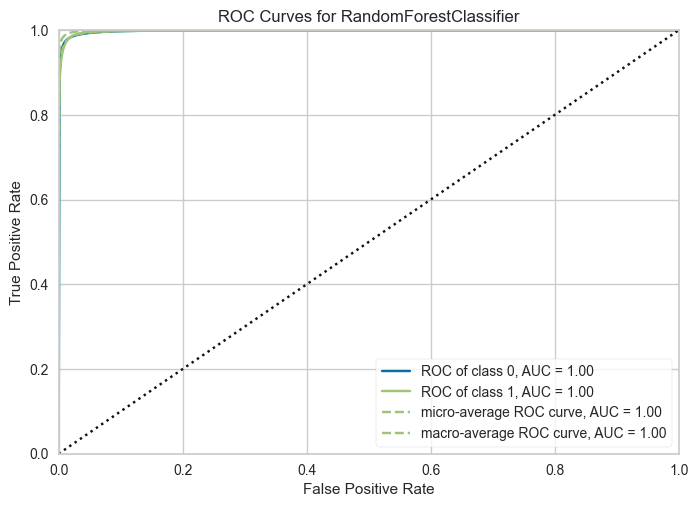

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [11]:
#ROC curve
roc_auc = ROCAUC(model, classes=[0, 1])
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()

Visualising some masks

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


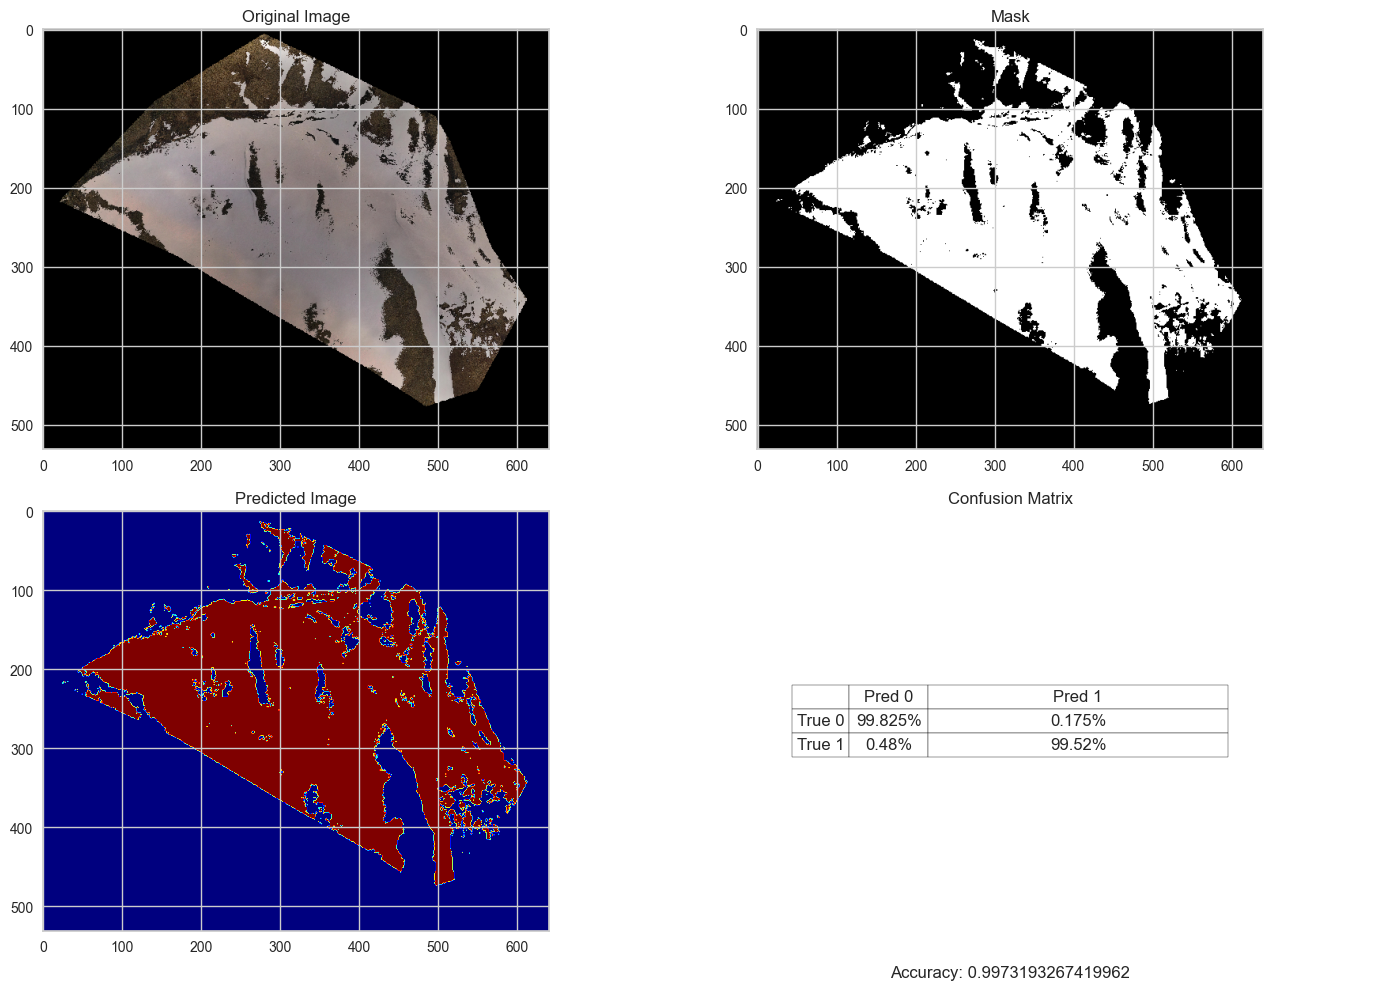

In [48]:
#open images
img = cv2.imread(csv_df['snow_path'][0])
mask = rasterio.open(csv_df['snowbinary_path'][0])


img_df_labeled = image_to_df(csv_df['snow_path'][0], csv_df['snowbinary_path'][0])
img_df = img_df_labeled.drop(labels=['labels'], axis=1)

#get predicition
pred_img = model.predict(img_df)
#reshape
pred_img_reshaped = pred_img.reshape((img.shape[0], img.shape[1]))

#check_accuracy
new_Y = img_df_labeled['labels'].values

#display prediction
visualize(img, mask, pred_img_reshaped,metrics.accuracy_score(new_Y, pred_img), confusion_matrix(new_Y, pred_img))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


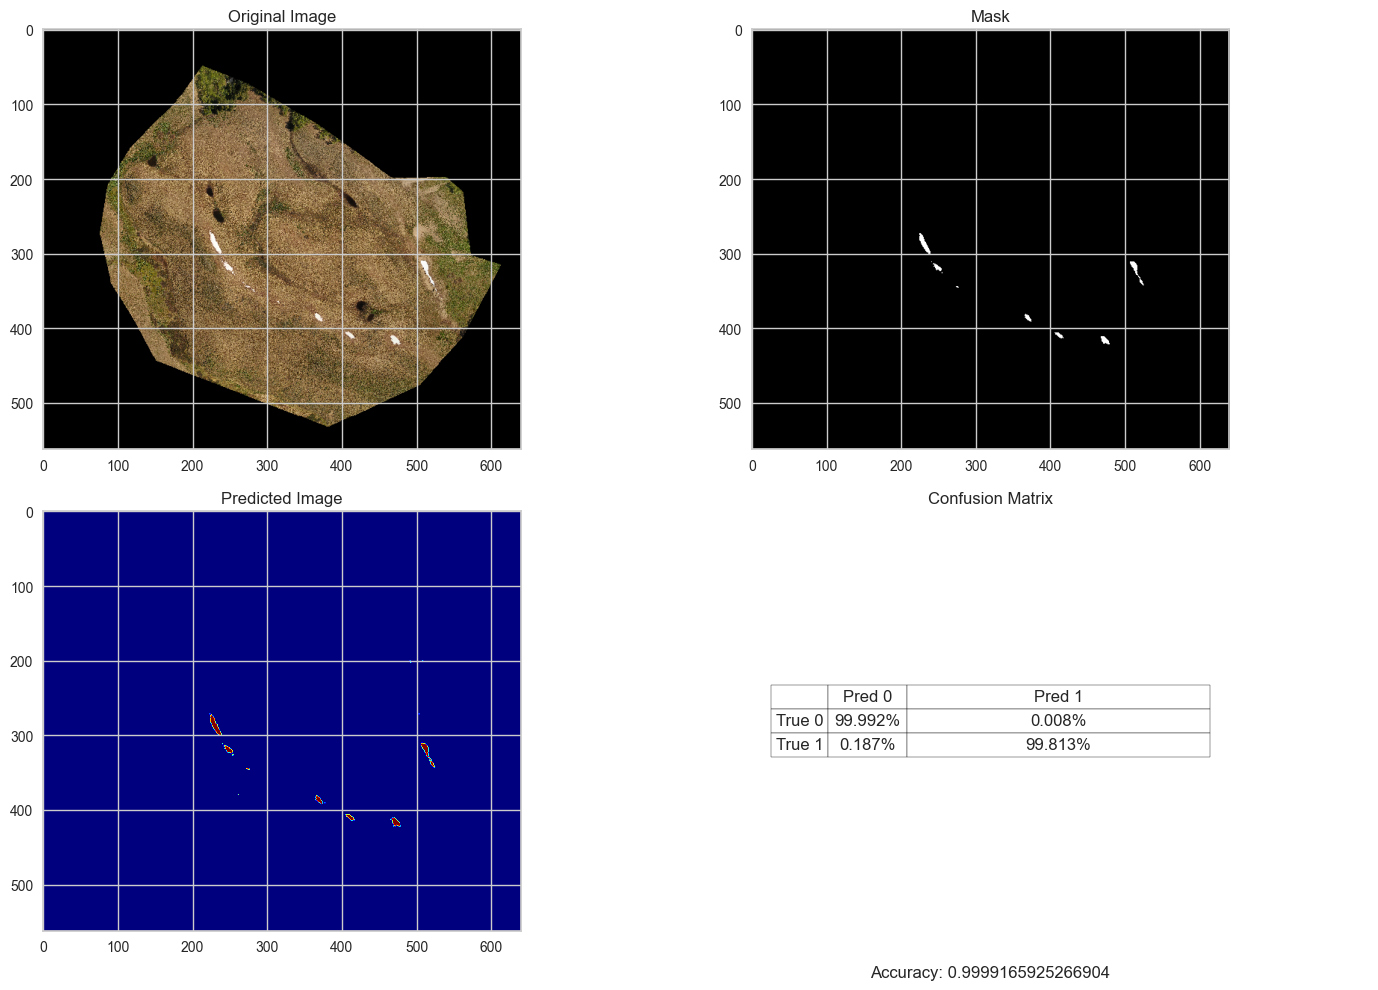

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished
C:\Users\apfox\AppData\Local\Temp\ipykernel_60844\3504782617.py:22: RuntimeWarning: invalid value encountered in divide
  confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


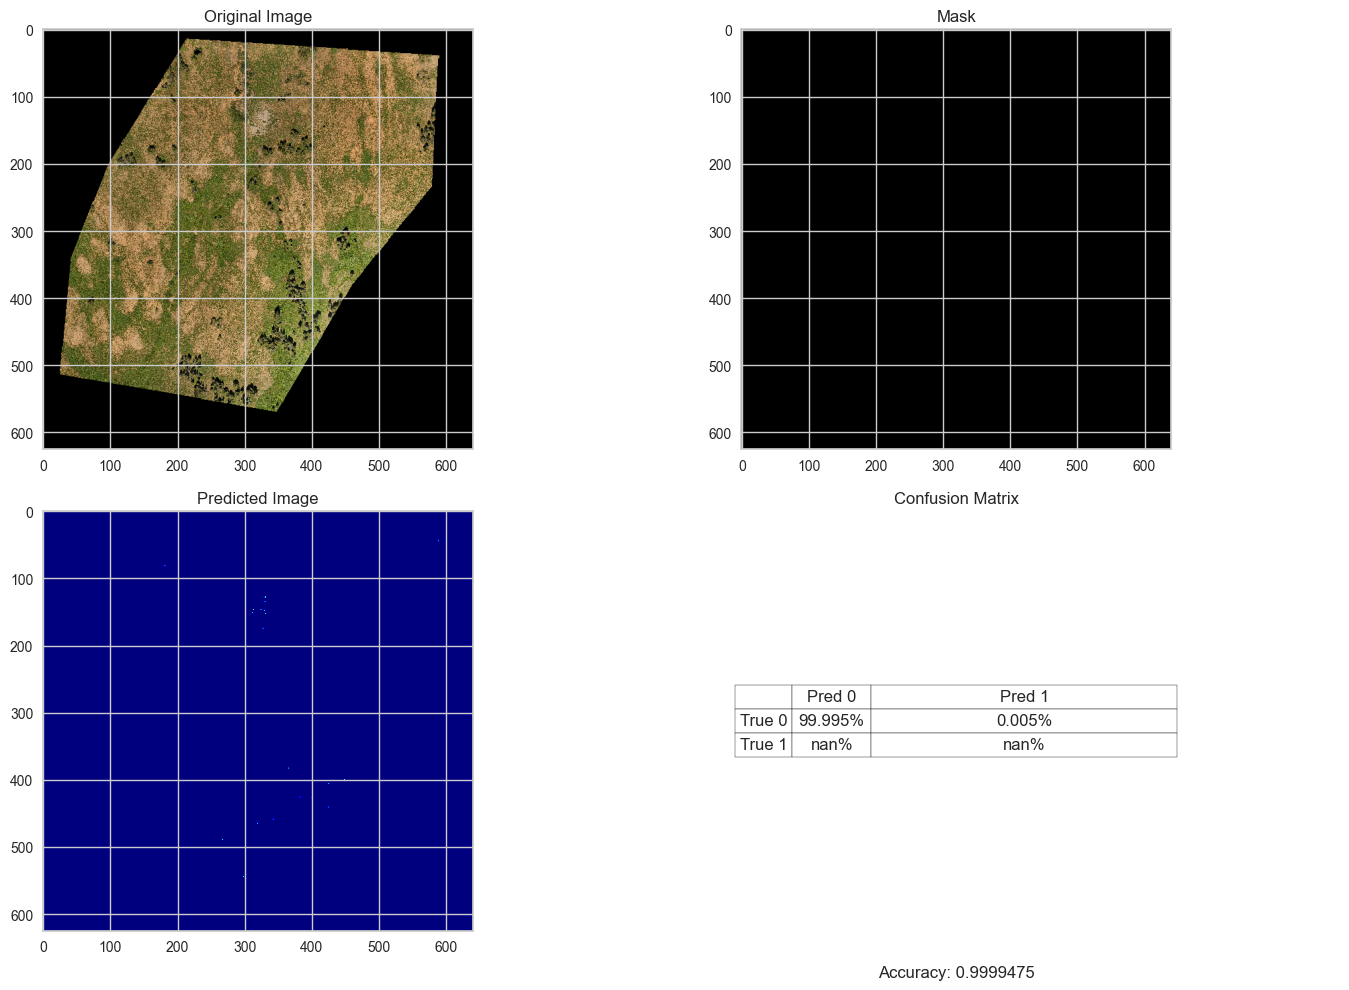

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished
C:\Users\apfox\AppData\Local\Temp\ipykernel_60844\3504782617.py:22: RuntimeWarning: invalid value encountered in divide
  confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


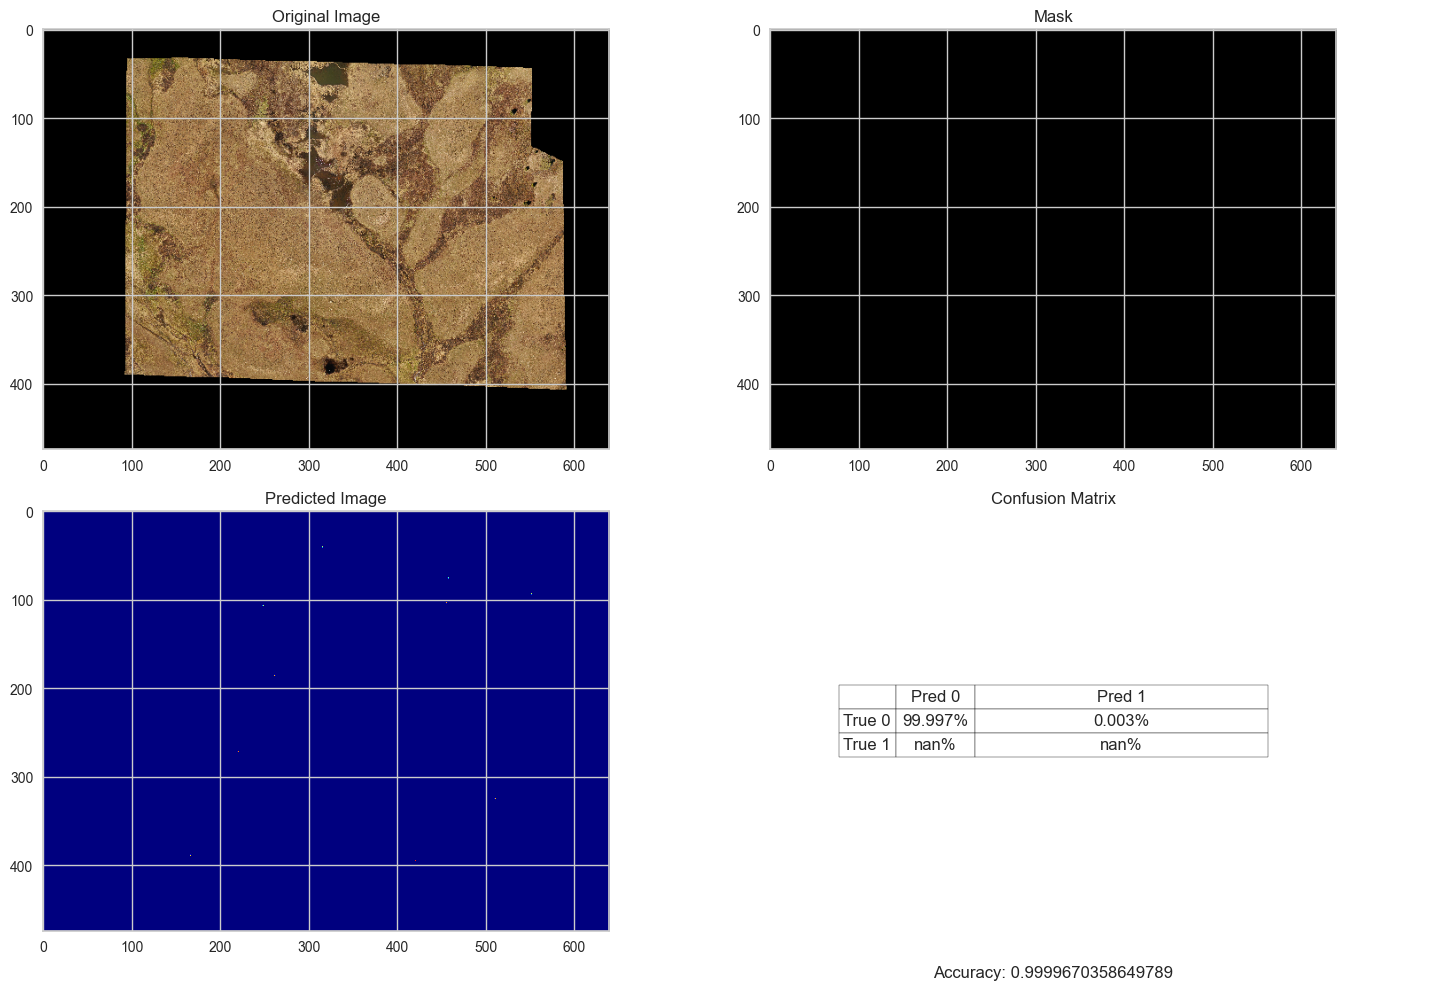

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished
C:\Users\apfox\AppData\Local\Temp\ipykernel_60844\3504782617.py:22: RuntimeWarning: invalid value encountered in divide
  confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


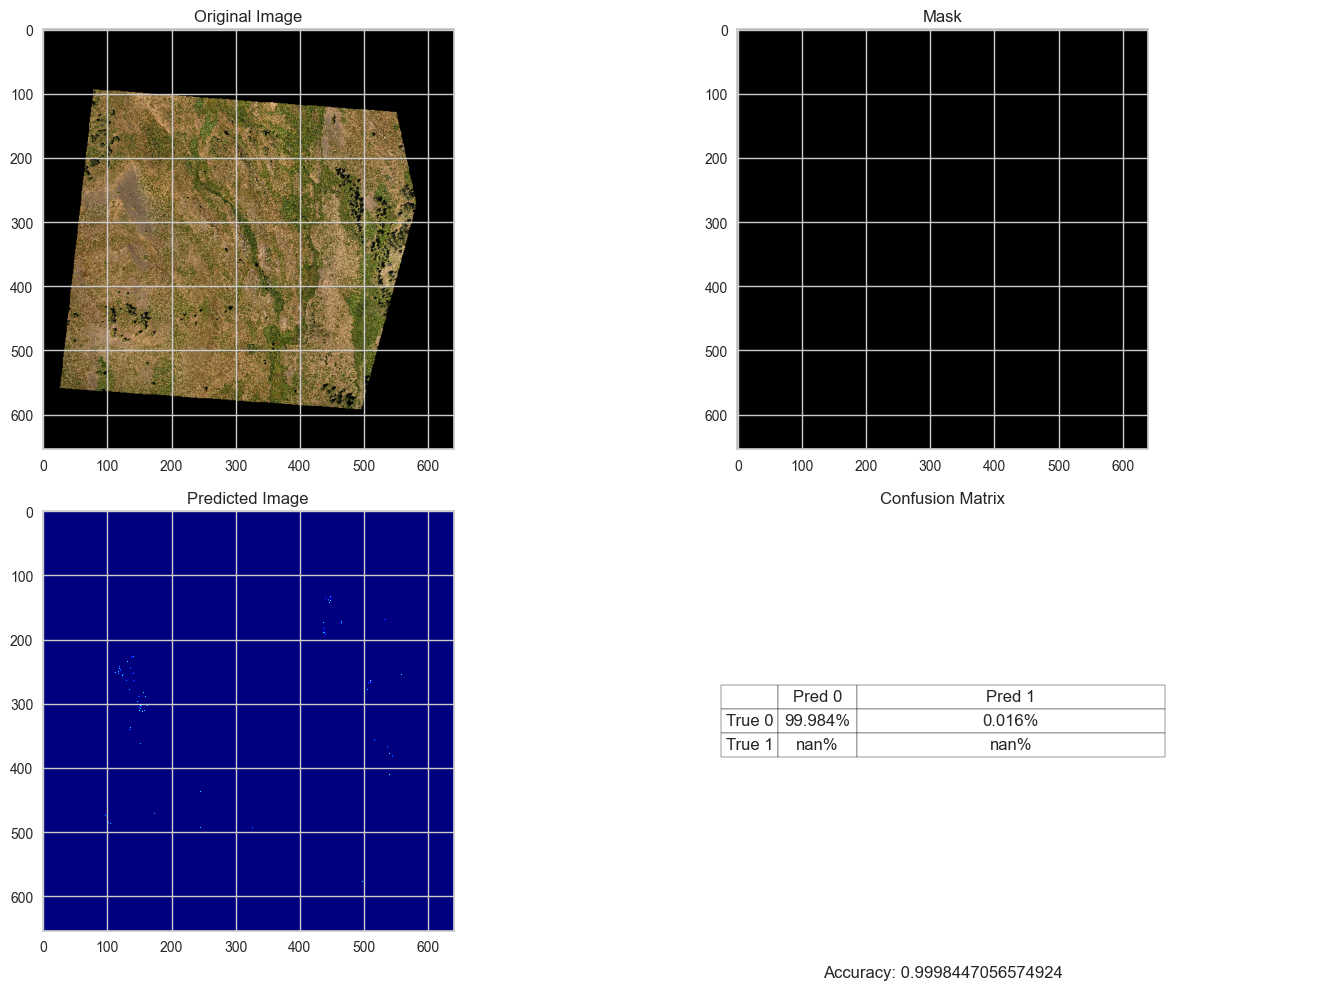

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


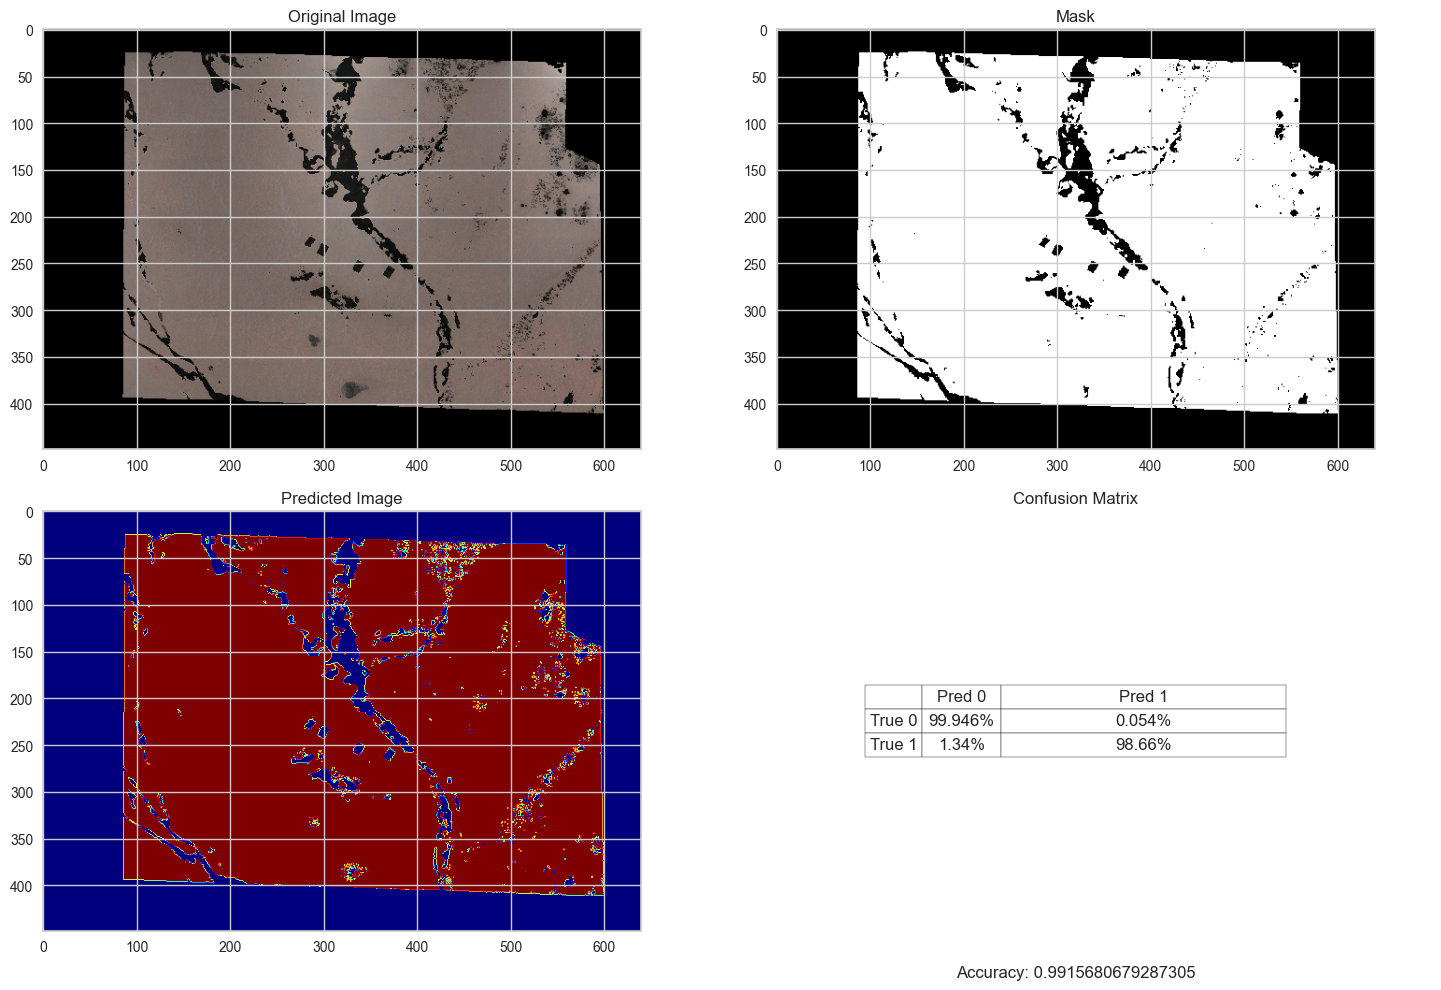

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


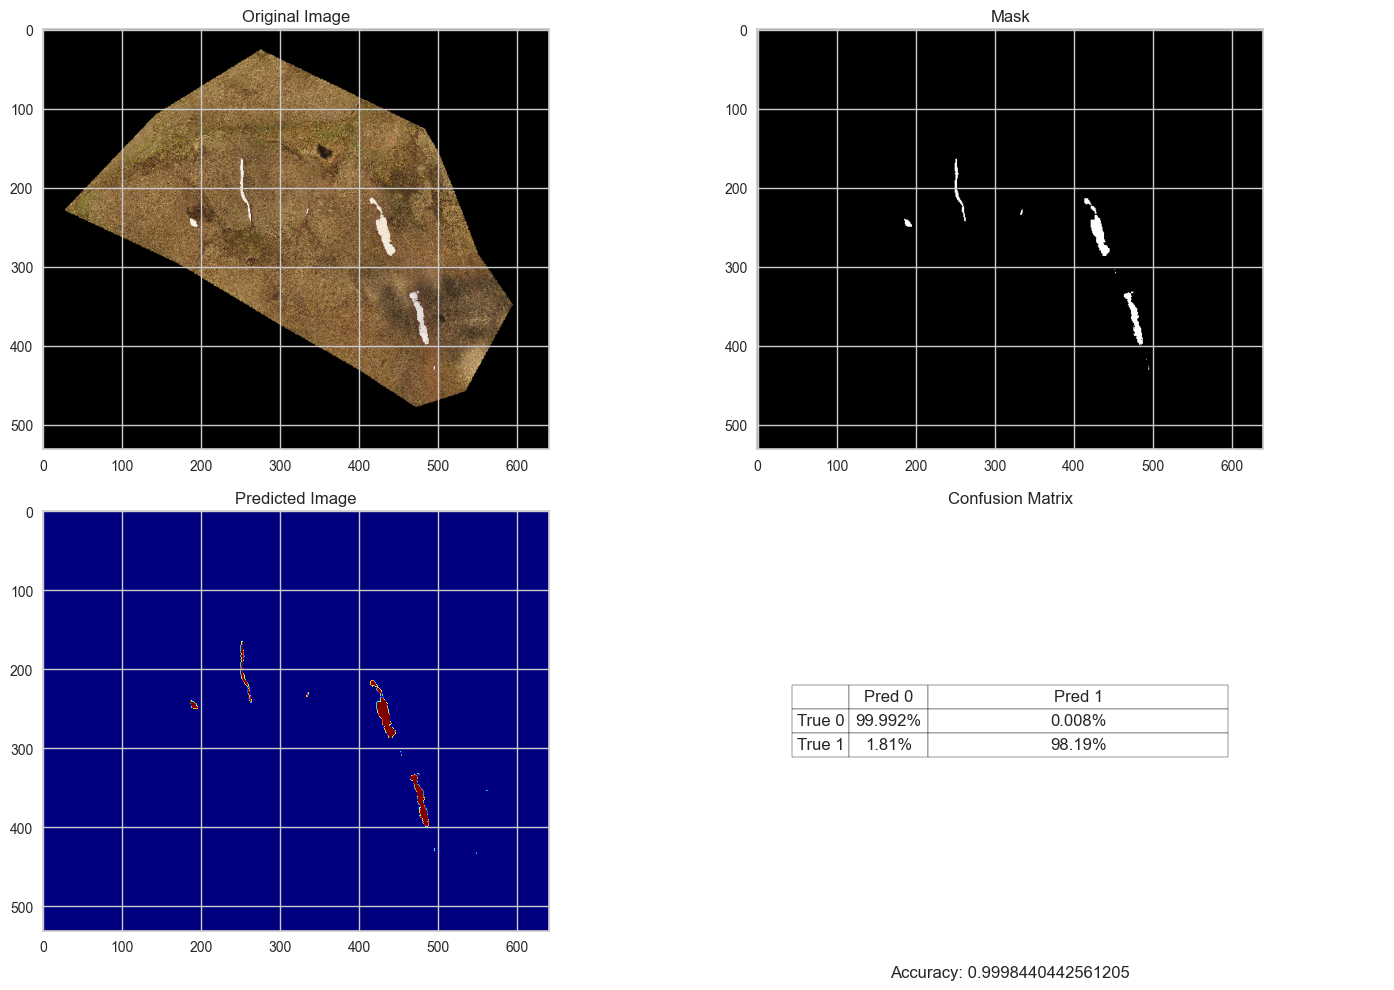

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.5s finished


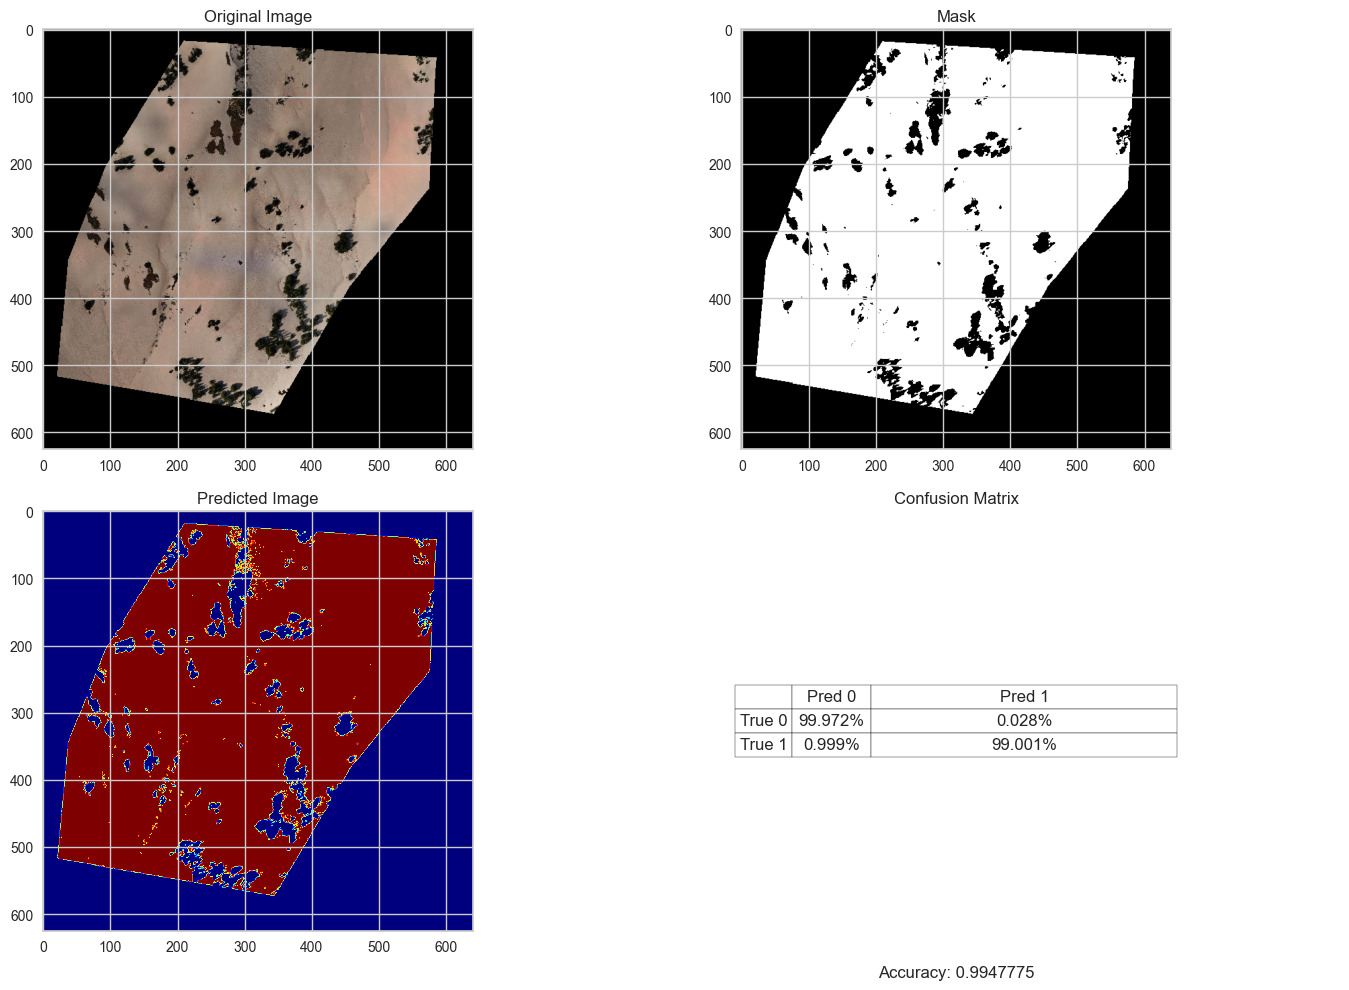

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


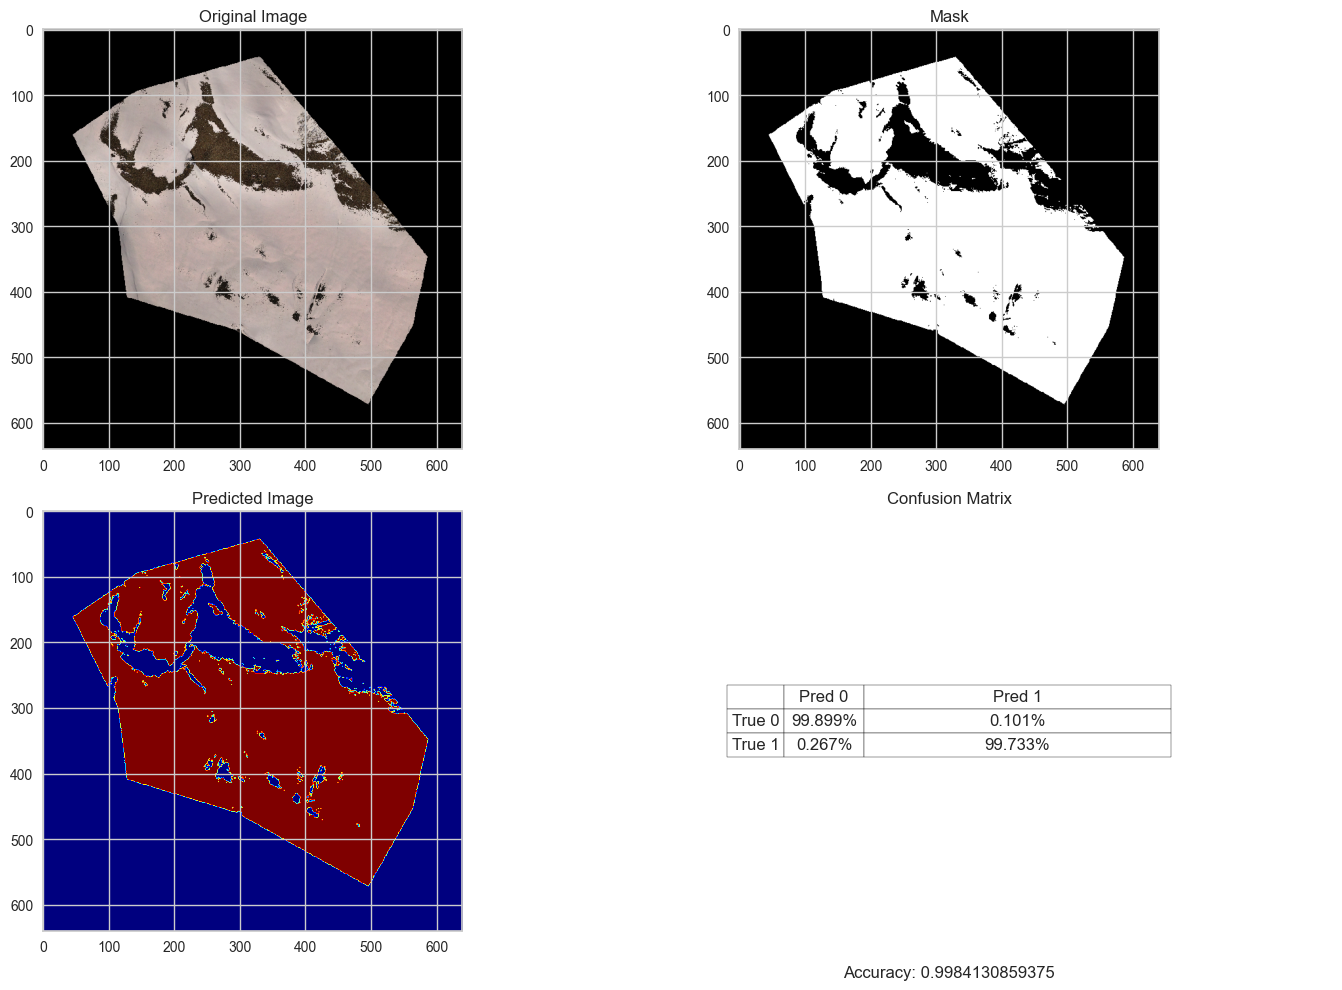

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


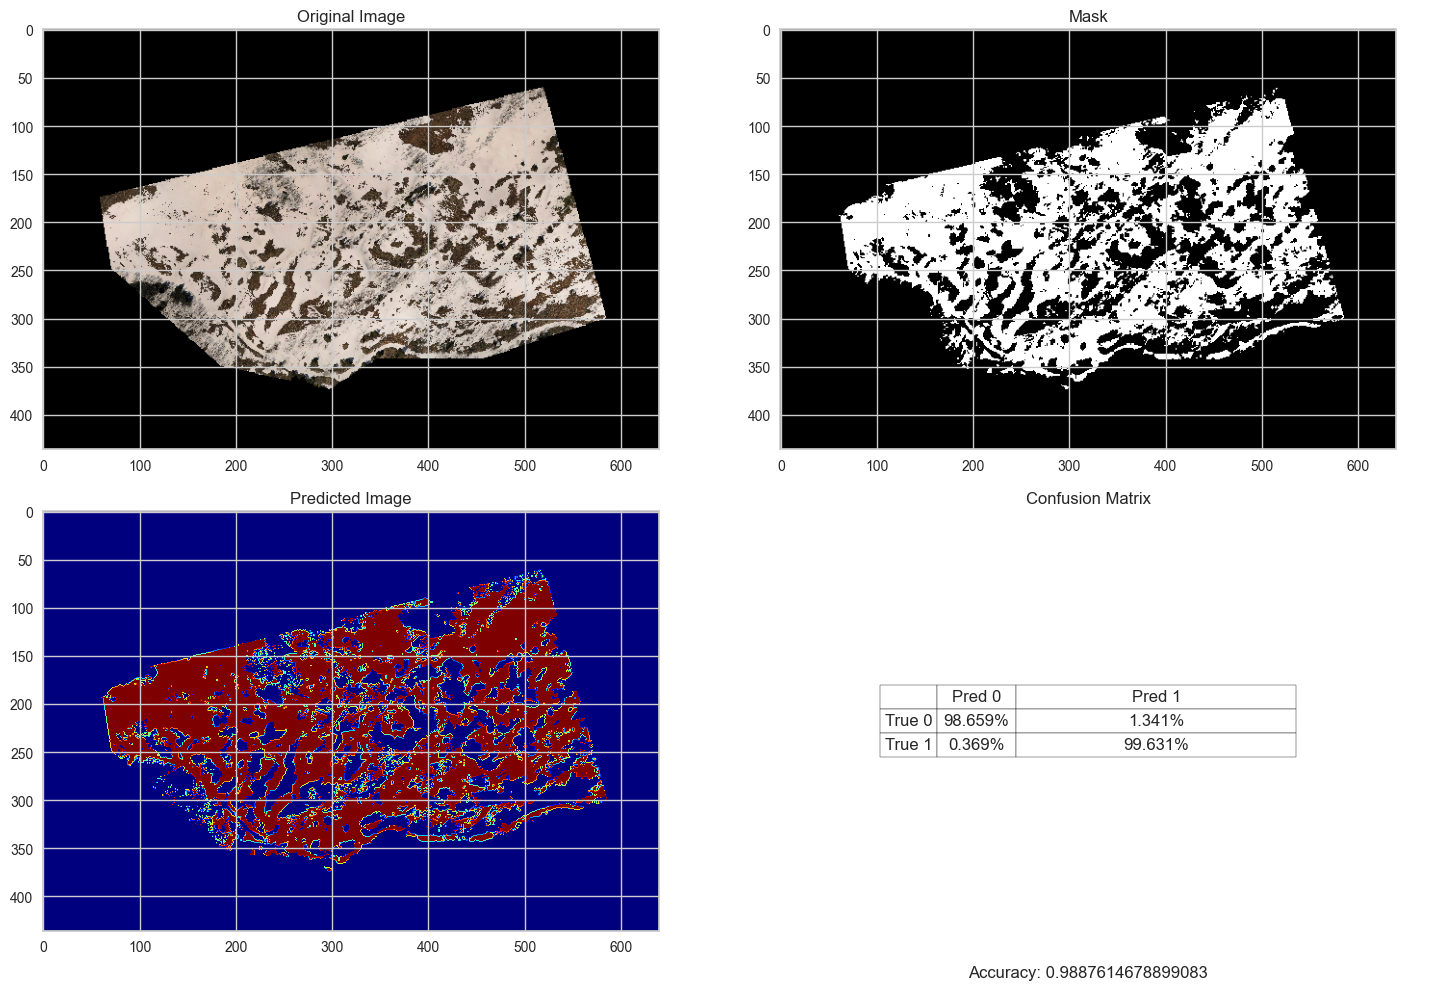

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.8s finished


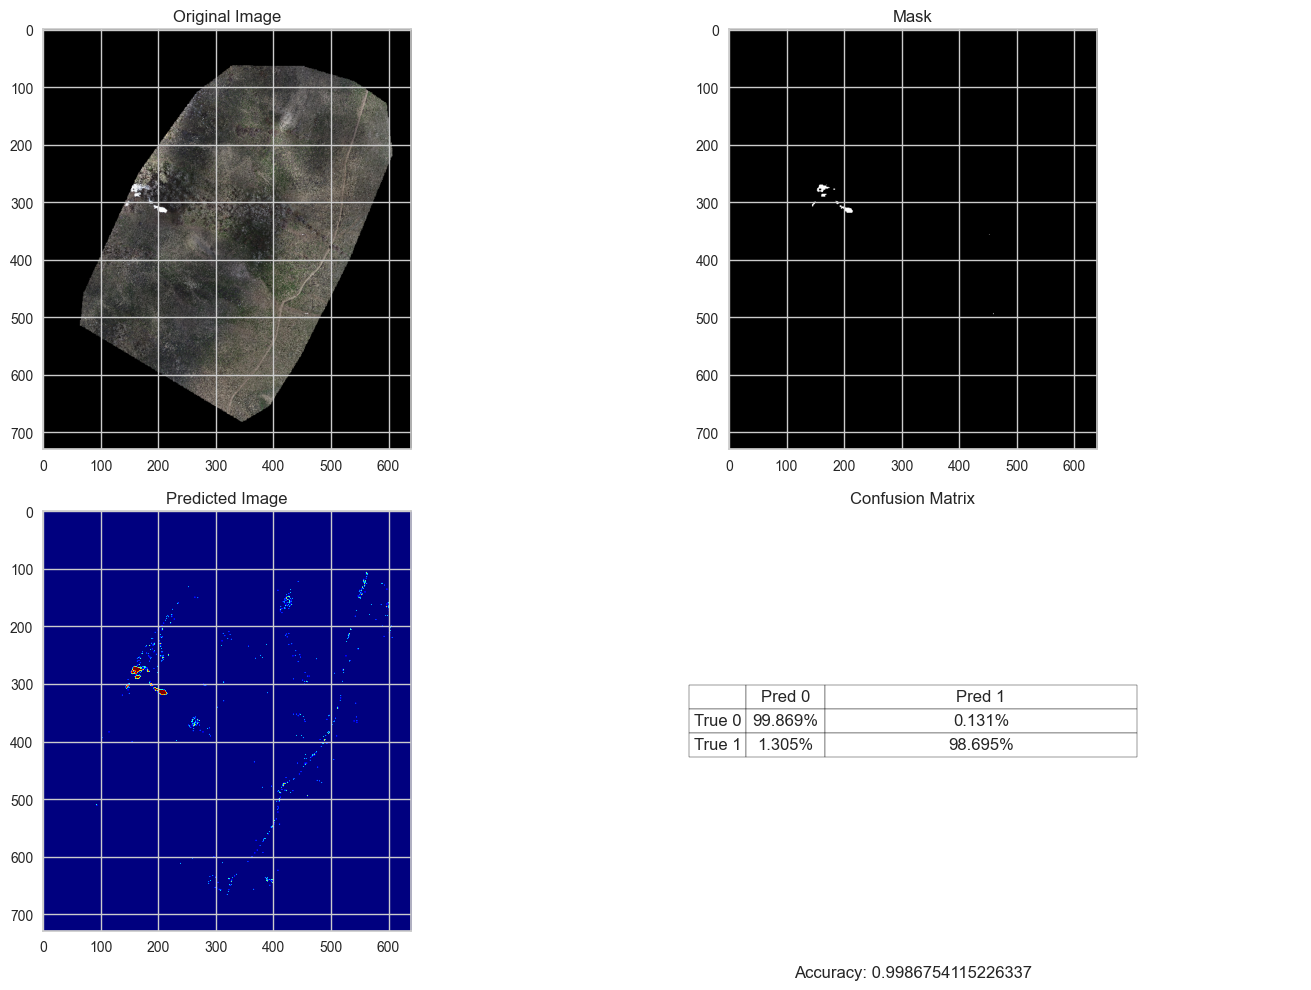

In [60]:
NUM_IMAGES = 10

#choose random images to test
random_images = csv_df.sample(NUM_IMAGES)

accuracies = []
confusion_matrices = []

#loop through images
for i in range(NUM_IMAGES):
    #open images
    img = cv2.imread(random_images['snow_path'].iloc[i])
    mask = rasterio.open(random_images['snowbinary_path'].iloc[i])

    #preprocessing
    img_df_labeled = image_to_df(random_images['snow_path'].iloc[i], random_images['snowbinary_path'].iloc[i])
    img_df = img_df_labeled.drop(labels=['labels'], axis=1)

    #get predicition
    pred_img = model.predict(img_df)

    #reshape
    pred_img_reshaped = pred_img.reshape((img.shape[0], img.shape[1]))

    #check_accuracy
    new_Y = img_df_labeled['labels'].values
    accuracy = metrics.accuracy_score(new_Y, pred_img)
    accuracies.append(accuracy)

    #get confusion matrices
    cm = confusion_matrix(new_Y, pred_img)
    confusion_matrices.append(cm)

    #display prediction
    visualize(img, mask, pred_img_reshaped,accuracy=accuracy, confusion_matrix=cm)

In [62]:
avg_accuracy = np.mean(accuracies)
avg_accuracy

0.9971715411584053

In [64]:
#sum all confusion matrices into one
total_cm = np.sum(confusion_matrices, axis=0)

#turn into percent
total_cm = total_cm.astype('float') / total_cm.sum(axis=1)[:, np.newaxis]
total_cm

array([[0.99868212, 0.00131788],
       [0.00858469, 0.99141531]])

In [85]:
#test all images
master_df = csv_df.copy()

accuracies = []
confusion_matrices = []



for i in range(len(master_df)):
    #open images
    img = cv2.imread(master_df.loc[i, 'snow_path'])
    mask = rasterio.open(master_df.loc[i, 'snowbinary_path'])

    #preprocessing
    img_df_labeled = image_to_df(master_df.loc[i, 'snow_path'], master_df.loc[i, 'snowbinary_path'])
    img_df = img_df_labeled.drop(labels=['labels'], axis=1)

    #get predicition
    pred_img = model.predict(img_df)

    #reshape
    pred_img_reshaped = pred_img.reshape((img.shape[0], img.shape[1]))

    #check_accuracy
    new_Y = img_df_labeled['labels'].values
    accuracy = metrics.accuracy_score(new_Y, pred_img)
    accuracies.append(accuracy)

    #get confusion matrices
    cm = confusion_matrix(new_Y, pred_img)
    confusion_matrices.append(cm)


    #display prediction
    # visualize(img, mask, pred_img_reshaped,accuracy=accuracy, confusion_matrix=cm)
    

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_job

In [88]:
#get averages
avg_accuracy = np.mean(accuracies)
print(avg_accuracy)

total_cm = np.sum(confusion_matrices, axis=0)
avg_cm = total_cm.astype('float') / total_cm.sum(axis=1)[:, np.newaxis]
print(total_cm)

0.9976158604719176


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (131,) + inhomogeneous part.

In [92]:
#find 5 worst performing images
worst_indices = np.argsort(accuracies)[:5]
worst_indices

array([32, 58, 40, 57, 68], dtype=int64)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.8s finished


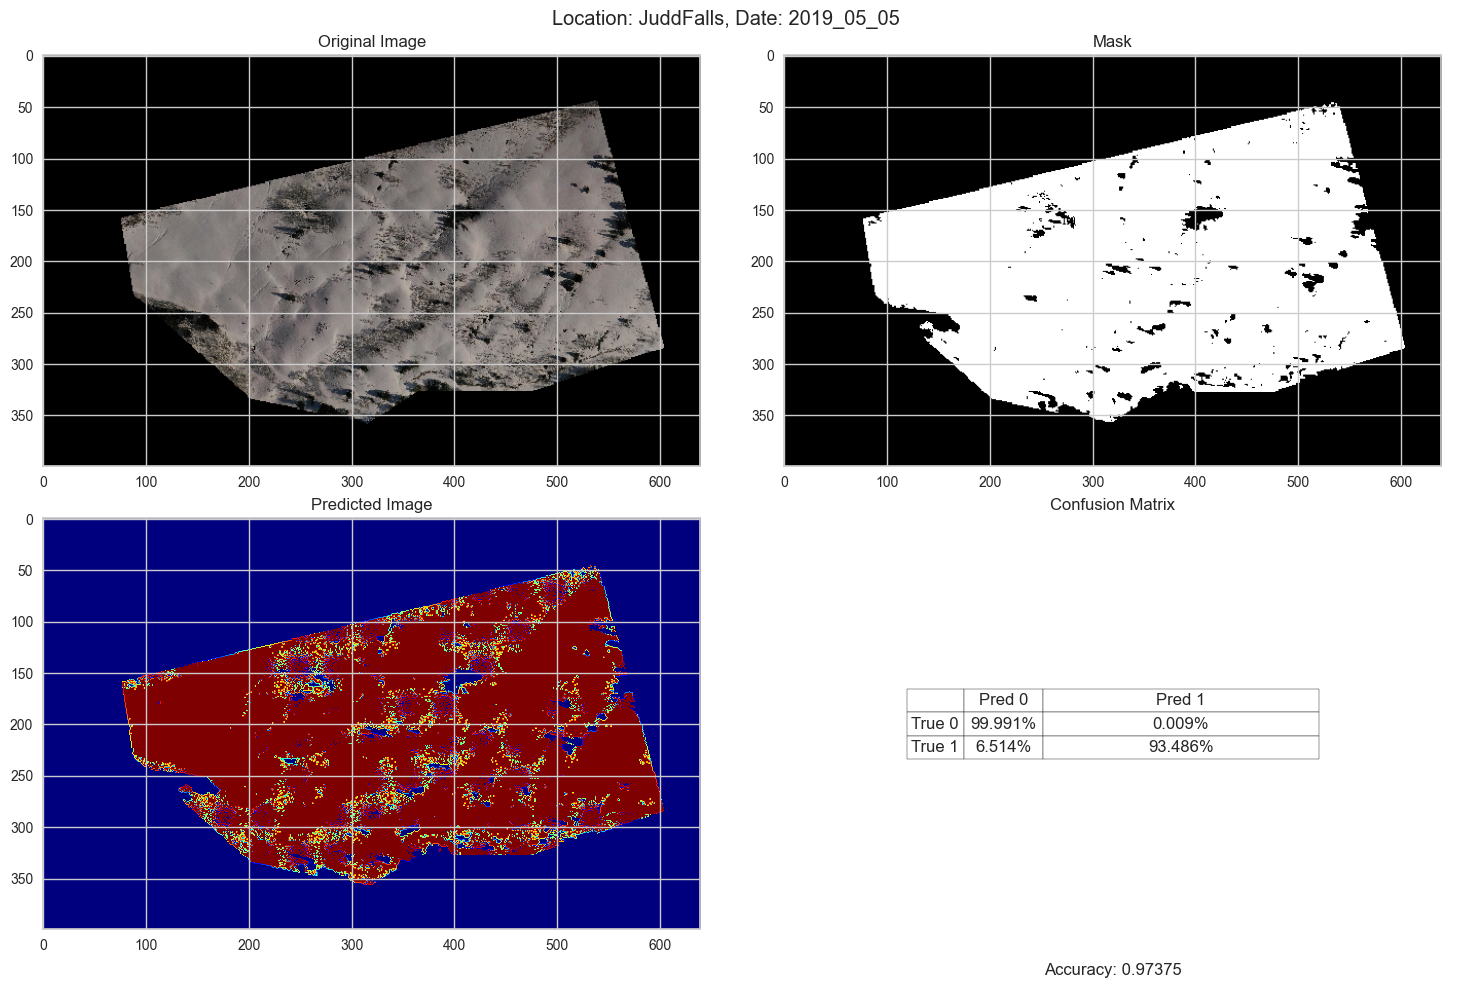

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.6s finished


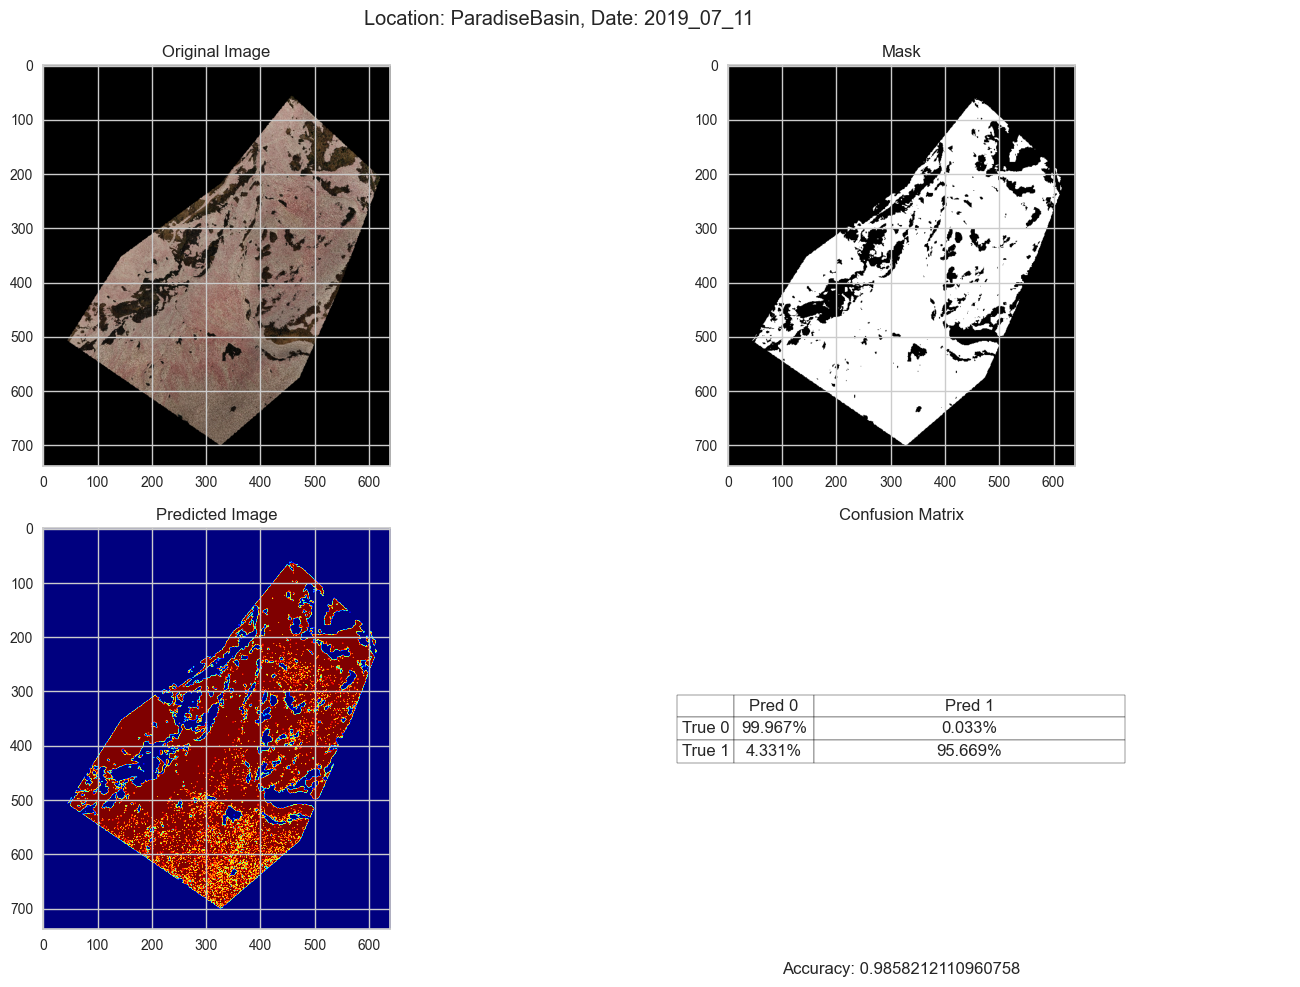

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


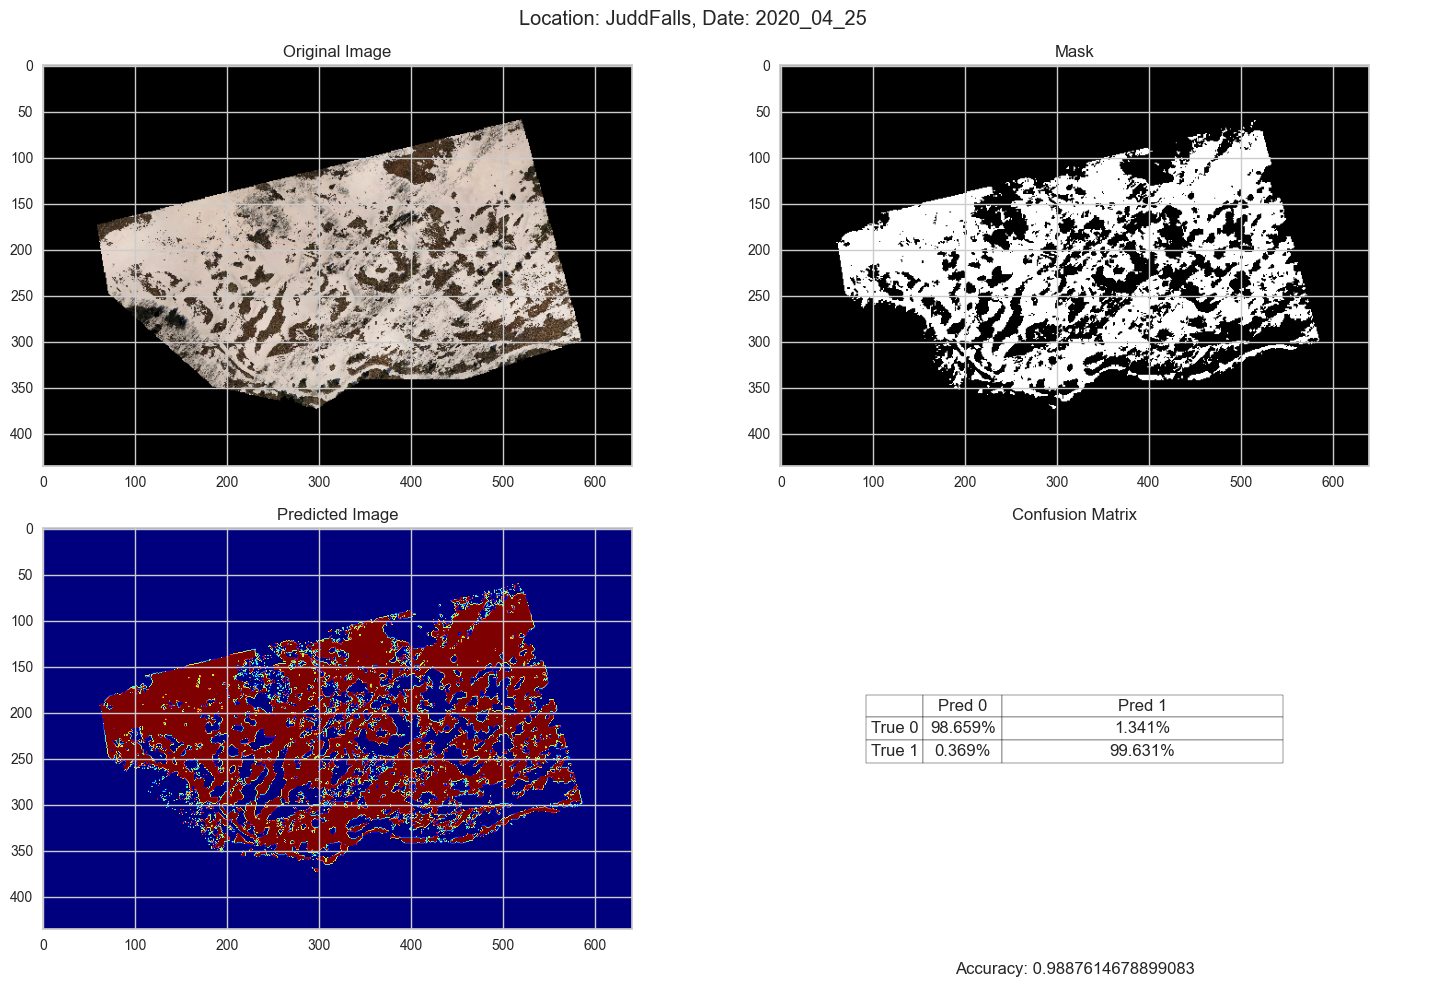

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.1s finished


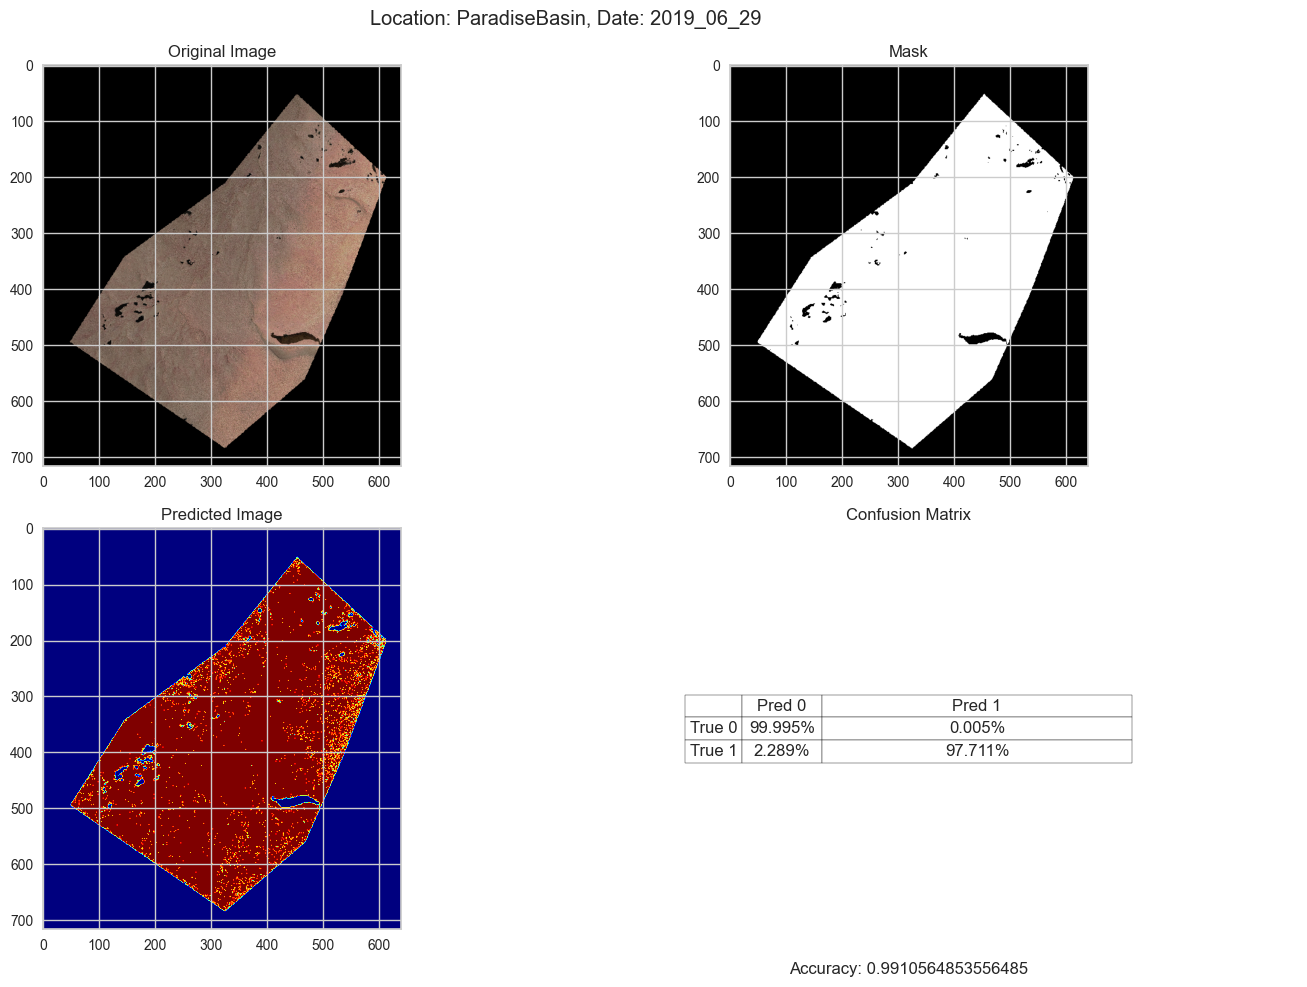

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.2s finished


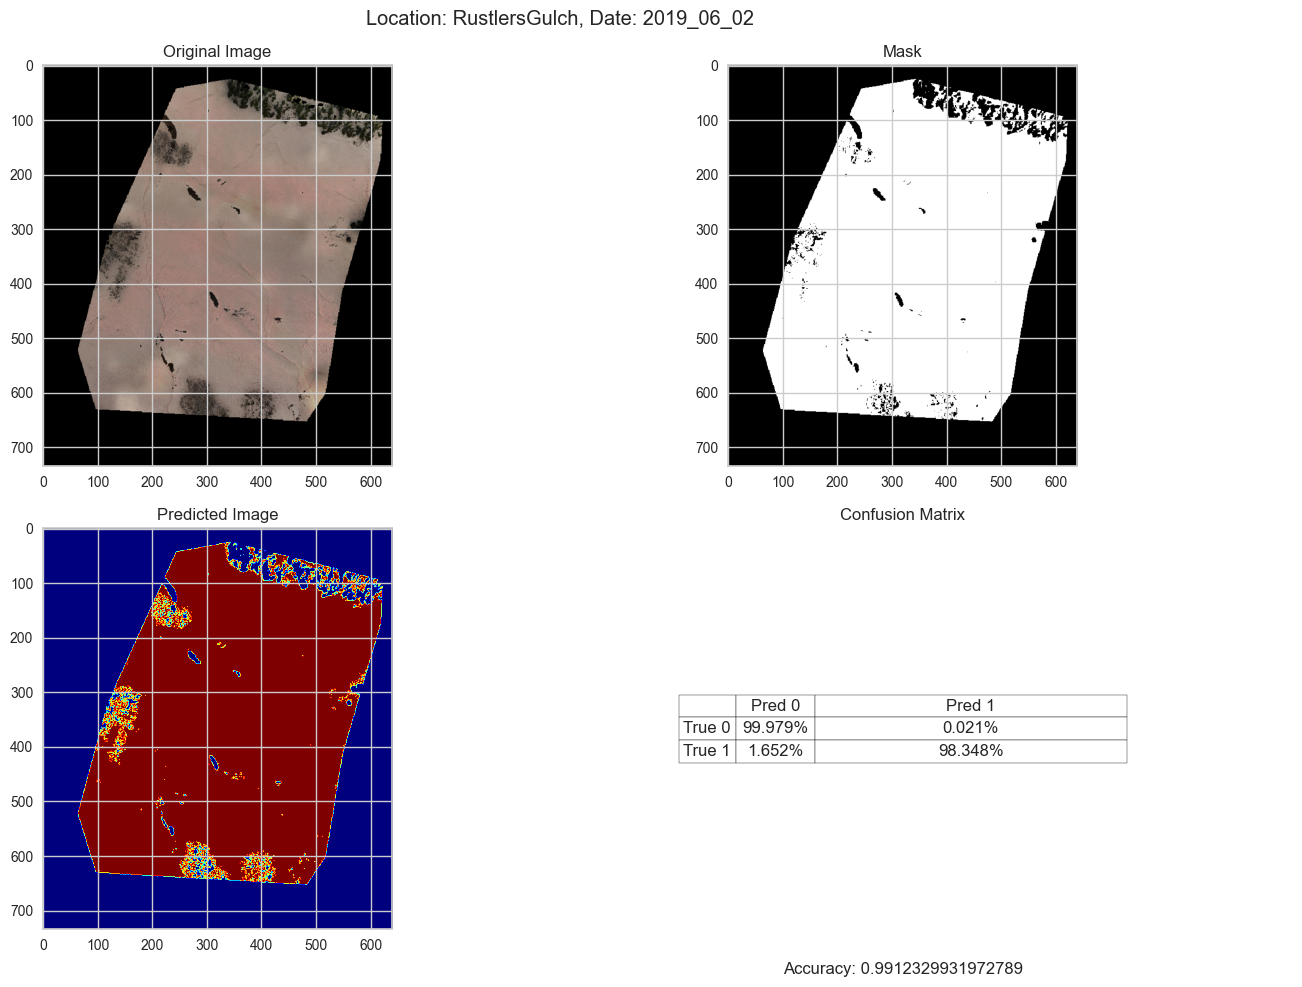

In [93]:
#display worst performing images

for i in worst_indices:
    img = cv2.imread(master_df.loc[i, 'snow_path'])
    mask = rasterio.open(master_df.loc[i, 'snowbinary_path'])

    img_df_labeled = image_to_df(master_df.loc[i, 'snow_path'], master_df.loc[i, 'snowbinary_path'])
    img_df = img_df_labeled.drop(labels=['labels'], axis=1)

    pred_img = model.predict(img_df)
    pred_img_reshaped = pred_img.reshape((img.shape[0], img.shape[1]))

    new_Y = img_df_labeled['labels'].values
    accuracy = metrics.accuracy_score(new_Y, pred_img)

    cm = confusion_matrix(new_Y, pred_img)

    visualize(img, mask, pred_img_reshaped,accuracy=accuracy, confusion_matrix=cm, location=master_df.loc[i, 'location'], date=master_df.loc[i, 'date'])

In [5]:
#lets do a grid search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [5,10, 15, 25, 50],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#set up model
rf = RandomForestClassifier(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

#get data
X = images_df.drop(labels=['labels'], axis=1)
y = images_df['labels'].values

# Fit the grid search to the data
grid_search.fit(X, y)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
